In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
start = dt.datetime.now()

In [3]:
DP_DIR = '../input/train/'
INPUT_DIR = '../input/'
TEST_DIR = '../input/test/'

TRAIN_CSV = os.path.join(INPUT_DIR, "train.csv")

BASE_SIZE = 256
NCATS = 5005
np.random.seed(seed=1986)
tf.set_random_seed(seed=1986)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    train_csv = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
    return train_csv["Id"].value_counts().index

In [4]:
def apk(actual, predicted, k=5):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :5], columns=['a', 'b', 'c', 'd', 'e'])

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [24]:
train_df = pd.read_csv(TRAIN_CSV)
labels = train_df.Id.value_counts()
labels_map = dict(zip(labels.index,range(len(labels.index))))
labels_map_r = dict(zip(range(len(labels.index)), labels.index))
train_df.shape[0]

25361

In [8]:
# Image config
SIZE = 64
data_files = os.listdir(os.path.join(INPUT_DIR, 'train'))
BATCH_SIZE = 299
shape = BATCH_SIZE, SIZE, SIZE, 3

EPOCHS = 20
STEP =80

In [25]:
train_df = train_df.sample(frac=1)
train_df_v = train_df[: train_df.shape[0] - BATCH_SIZE * 80]
train_df_t = train_df[train_df.shape[0] - BATCH_SIZE * 80 : ]

In [10]:
def get_image(image_path, width, height, mode):
    image = Image.open(image_path)
    image = image.resize([width, height], Image.BILINEAR) 
    return np.array(image.convert(mode))

def image_generator_xd(size, batchsize):
    while True:
        for i in range(STEP):
            df = train_df_t [i * batchsize: (i+1) * batchsize]
            x = np.zeros((len(df), size, size, 3))
            for i, im_file in enumerate(df.Image.values):
                x[i, :, :, :] = get_image(os.path.join(DP_DIR, im_file), size, size,
                                         mode='RGB')
            x = preprocess_input(x).astype(np.float32)
            y = keras.utils.to_categorical(df.Id.apply(lambda x: labels_map[x]), num_classes=NCATS)
            yield x, y
            
def df_to_image_array_xd(df, size=SIZE):
    x = np.zeros((len(df), size, size, 3))
    for i, im_file in enumerate(df.Image.values):
        x[i, :, :, :] = get_image(os.path.join(DP_DIR, im_file), size, size, mode='RGB')
    x = preprocess_input(x).astype(np.float32)
    return x

In [11]:
valid_df = train_df_v
x_valid = df_to_image_array_xd(valid_df)
y_valid = keras.utils.to_categorical(valid_df.Id.apply(lambda x: labels_map[x]), num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(1441, 64, 64, 3) (1441, 5005)
Validation array memory 0.07 GB


In [12]:
model = MobileNet(input_shape=(SIZE, SIZE, 3), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________

In [13]:
train_datagen = image_generator_xd(size=SIZE, batchsize=BATCH_SIZE)

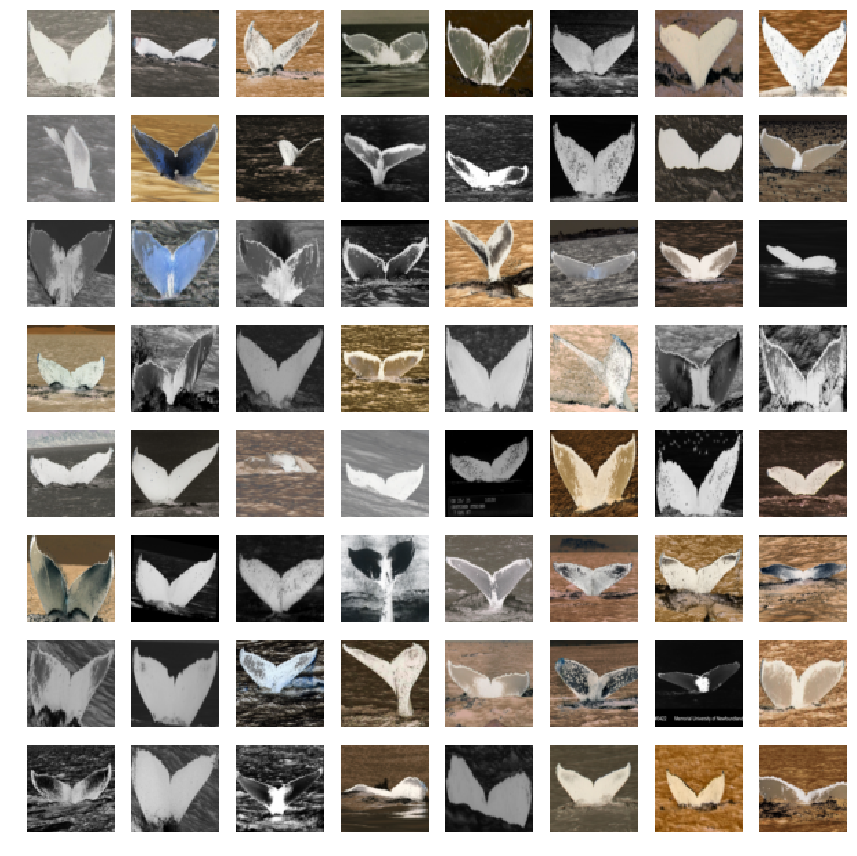

In [14]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, :] + 1)/2, cmap=plt.cm.RdYlBu)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [15]:
%%timeit
x, y = next(train_datagen)

3.92 s ± 94.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
x.shape
y.shape
x_valid.shape
y_valid.shape

(299, 64, 64, 3)

(299, 5005)

(1441, 64, 64, 3)

(1441, 5005)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_5_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_5_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=80, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [ ]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map5 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map5: {:.3f}'.format(map5))

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

In [21]:
def files_to_image_array_xd(files, size=SIZE):
    x = np.zeros((len(files), size, size, 3))
    for i, im_file in enumerate(files):
        x[i, :, :, :] = get_image(os.path.join(TEST_DIR, im_file), size, size,
                                 mode='RGB')
    x = preprocess_input(x).astype(np.float32)
    return x

x_test = files_to_image_array_xd(os.listdir(TEST_DIR))
print(x_test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

(7960, 64, 64, 3) (7960, 64, 64, 3)
Test array memory 0.36 GB


In [ ]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top5 = preds2catids(test_predictions)
top5.head()
top5.shape

top5cats = top5.apply(lambda x: x: labels_map_r[x])
top5cats.head()
top5cats.shape

In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))
test['Image'] = os.listdir(TEST_DIR)
test['Id'] = top5cats['a'] + ' ' + top5cats['b'] + ' ' + top5cats['c'] + ' ' + top5cats['d'] + ' ' + top5cats['e']
submission = test[['Image', 'Id']]
submission.to_csv('submission.csv'.format(int(map5 * 10**4)), index=False)
submission.head()
submission.shape